In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
import cv2
import glob

2024-02-23 20:35:31.432230: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 20:35:31.520025: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-23 20:35:32.184101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 20:35:32.184606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 20:35:32.269276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [73]:
data_dir = '/home/aracely/aitraveling/cities'
labels = ["agra", "cdmx", "dubai", "newyork", "paris", "shanhaiguan"]
for label in labels:
    image_count = len(glob.glob(data_dir+"/"+label+"/*"))
    print(label+": "+str(image_count))

agra: 300
cdmx: 299
dubai: 300
newyork: 300
paris: 300
shanhaiguan: 300


In [74]:
images = {}
for label in labels:
    images[label] = glob.glob(data_dir+"/"+label+"/*")
# imgs_china = glob.glob(data_dir+"/china/*")
# imgs_india = glob.glob(data_dir+"/india/*")
# imgs_mexico = glob.glob(data_dir+"/mexico/*")

In [75]:
print(len(images["agra"]))

300


## Load data using a Keras utility

### Create a dataset

In [76]:
batch_size = 32
img_height = 180
img_width = 180

In [77]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1799 files belonging to 6 classes.
Using 1440 files for training.


In [78]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1799 files belonging to 6 classes.
Using 359 files for validation.


In [79]:
class_names = train_ds.class_names
print(class_names)

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan']


## Visualize the data

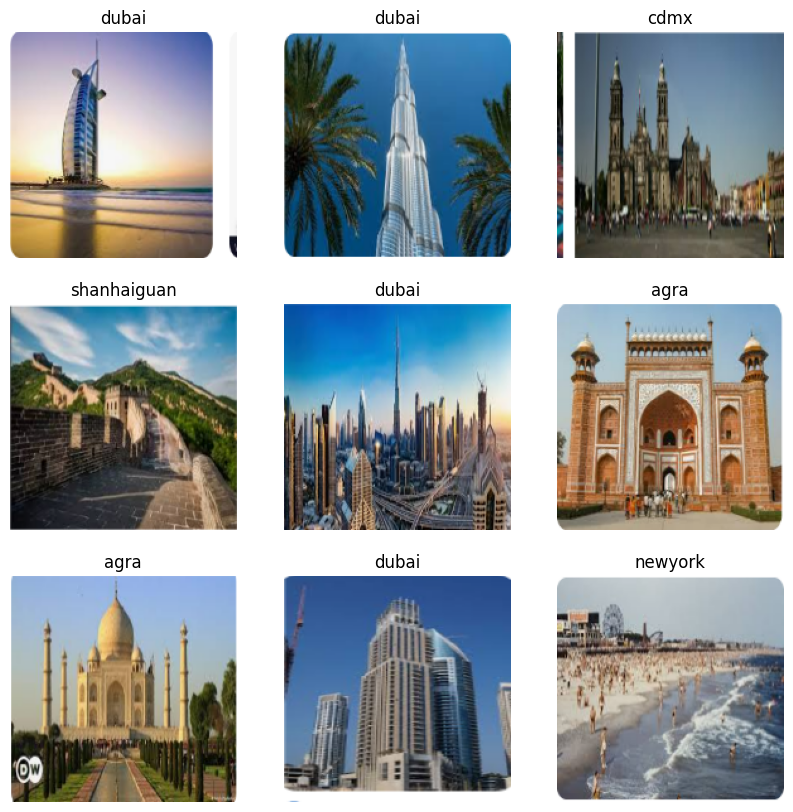

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [81]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [82]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [83]:
normalization_layer = layers.Rescaling(1./255)

In [84]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## A basic Keras model

### Create the model

In [85]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [86]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [87]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [88]:
epochs=12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
45/45 [==============================] - 13s 265ms/step - loss: 1.7350 - accuracy: 0.2896 - val_loss: 1.5220 - val_accuracy: 0.4234
Epoch 2/12
45/45 [==============================] - 11s 249ms/step - loss: 1.3181 - accuracy: 0.5146 - val_loss: 1.3547 - val_accuracy: 0.4930
Epoch 3/12
45/45 [==============================] - 11s 251ms/step - loss: 1.0371 - accuracy: 0.6139 - val_loss: 1.1878 - val_accuracy: 0.5571
Epoch 4/12
45/45 [==============================] - 11s 243ms/step - loss: 0.8667 - accuracy: 0.6903 - val_loss: 1.3016 - val_accuracy: 0.4986
Epoch 5/12
45/45 [==============================] - 11s 245ms/step - loss: 0.6072 - accuracy: 0.7875 - val_loss: 1.3579 - val_accuracy: 0.5460
Epoch 6/12
45/45 [==============================] - 11s 246ms/step - loss: 0.4441 - accuracy: 0.8438 - val_loss: 1.3018 - val_accuracy: 0.5850
Epoch 7/12
45/45 [==============================] - 11s 245ms/step - loss: 0.2456 - accuracy: 0.9167 - val_loss: 1.5500 - val_accuracy: 0.5599

## Visualize training results

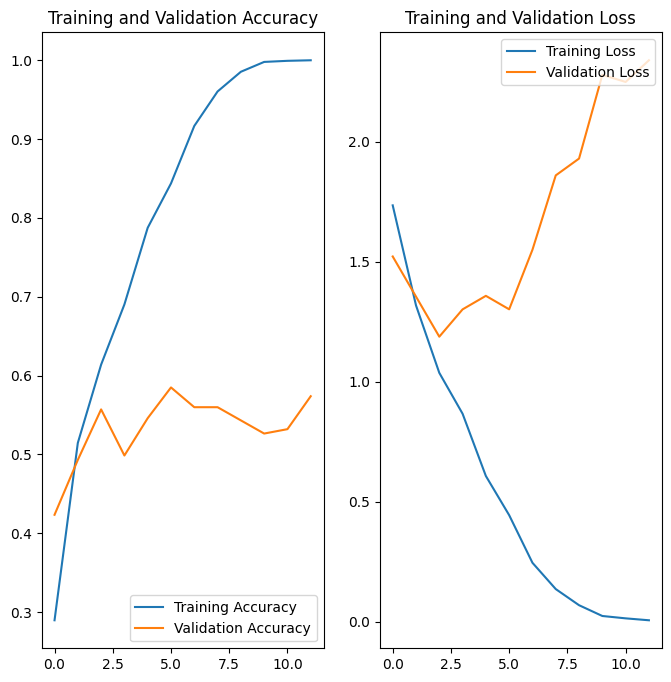

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

In [90]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

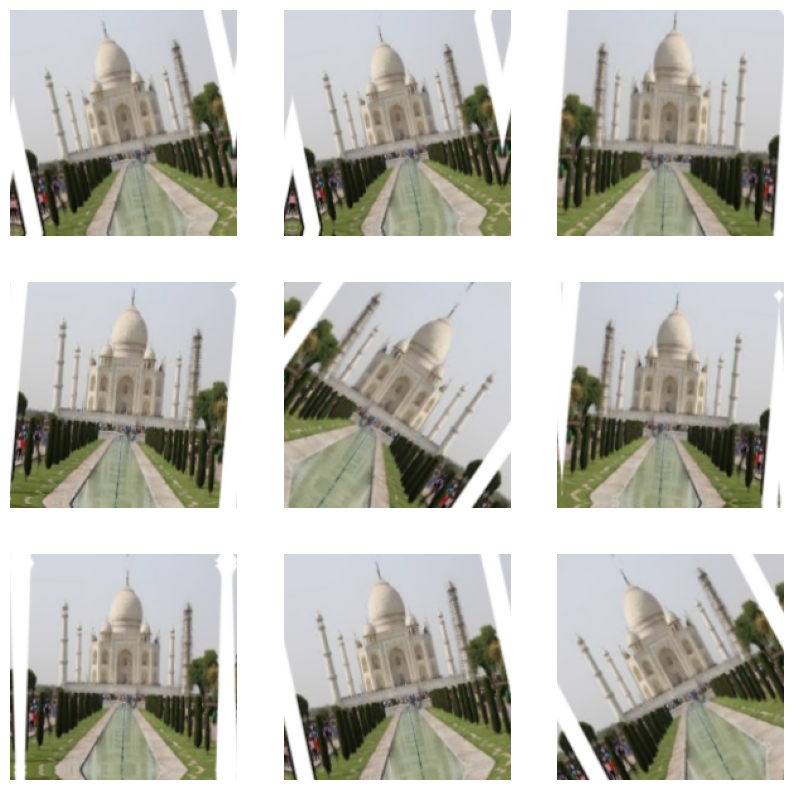

In [91]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [92]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [93]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [94]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [95]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
45/45 [==============================] - 16s 319ms/step - loss: 1.8610 - accuracy: 0.1910 - val_loss: 1.7543 - val_accuracy: 0.2173
Epoch 2/15
45/45 [==============================] - 14s 306ms/step - loss: 1.6828 - accuracy: 0.2889 - val_loss: 1.5633 - val_accuracy: 0.3705
Epoch 3/15
45/45 [==============================] - 15s 325ms/step - loss: 1.5531 - accuracy: 0.3688 - val_loss: 1.4819 - val_accuracy: 0.4290
Epoch 4/15
45/45 [==============================] - 14s 306ms/step - loss: 1.4533 - accuracy: 0.4153 - val_loss: 1.3963 - val_accuracy: 0.4485
Epoch 5/15
45/45 [==============================] - 14s 316ms/step - loss: 1.3495 - accuracy: 0.4757 - val_loss: 1.3511 - val_accuracy: 0.4568
Epoch 6/15
45/45 [==============================] - 14s 307ms/step - loss: 1.2904 - accuracy: 0.4910 - val_loss: 1.4124 - val_accuracy: 0.4540
Epoch 7/15
45/45 [==============================] - 14s 305ms/step - loss: 1.2679 - accuracy: 0.5229 - val_loss: 1.2669 - val_accuracy: 0.5042

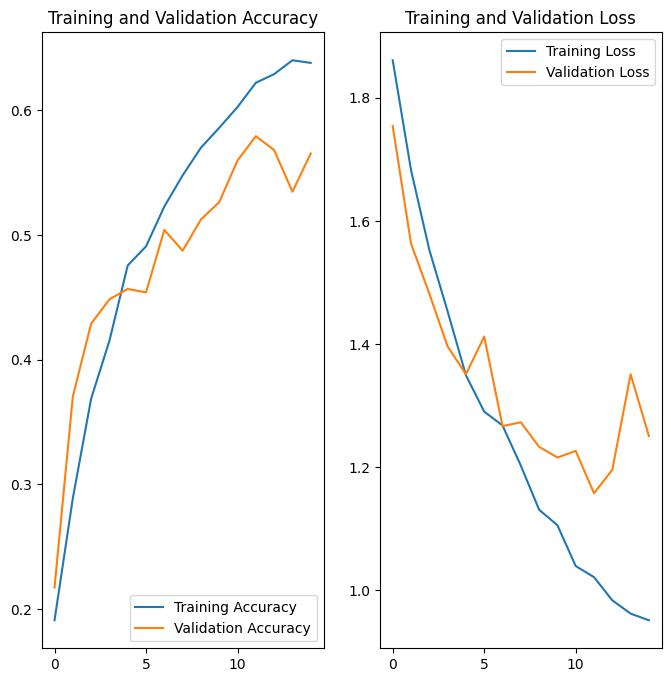

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [97]:
data_dir

'/home/aracely/aitraveling/cities'

1/1 [==============================] - 0s 106ms/step
This image most likely belongs to agra with a 90.33 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan']
[0.9032609  0.03438761 0.02435464 0.02216802 0.00987485 0.00595401]


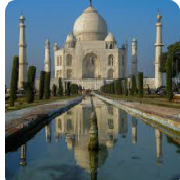

In [98]:
img = tf.keras.utils.load_img(
    data_dir+'/agra/(10403).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print()
print(class_names)
# print(type(score))
print(np.array(score))
img

1/1 [==============================] - 0s 32ms/step
This image most likely belongs to dubai with a 80.45 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan']
[2.4052241e-04 9.3740880e-02 8.0449909e-01 2.8087968e-02 7.3221527e-02
 2.0991045e-04]


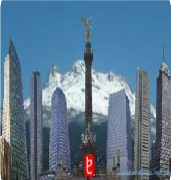

In [100]:
img2 = tf.keras.utils.load_img(
    data_dir+'/cdmx/(10130).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img2)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img2

1/1 [==============================] - 0s 43ms/step
This image most likely belongs to dubai with a 80.45 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan']
[2.4052241e-04 9.3740880e-02 8.0449909e-01 2.8087968e-02 7.3221527e-02
 2.0991045e-04]


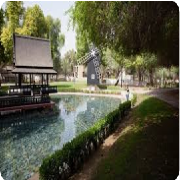

In [102]:
img = tf.keras.utils.load_img(
    data_dir+'/dubai/(10964).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img2)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img

1/1 [==============================] - 0s 40ms/step
This image most likely belongs to newyork with a 48.49 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan']
[1.7559494e-05 7.6847333e-03 4.3866080e-01 4.8491004e-01 6.8662852e-02
 6.3931548e-05]


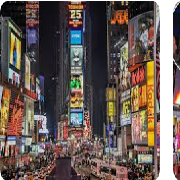

In [104]:
img3 = tf.keras.utils.load_img(
    data_dir+'/newyork/(1087).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img3)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img3

1/1 [==============================] - 0s 37ms/step
This image most likely belongs to paris with a 82.49 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan']
[0.02960121 0.01846957 0.07207111 0.0369327  0.8248587  0.01806668]


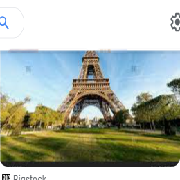

In [105]:
img4 = tf.keras.utils.load_img(
    data_dir+'/paris/(10239).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img4)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img4

1/1 [==============================] - 0s 41ms/step
This image most likely belongs to shanhaiguan with a 91.54 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan']
[0.02135005 0.03292508 0.01313934 0.01448511 0.00266839 0.91543204]


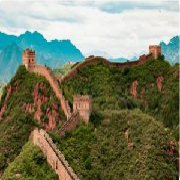

In [106]:
img5 = tf.keras.utils.load_img(
    data_dir+'/shanhaiguan/(10431).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img5

1/1 [==============================] - 0s 50ms/step
This image most likely belongs to shanhaiguan with a 91.54 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan']
[0.02135005 0.03292508 0.01313934 0.01448511 0.00266839 0.91543204]


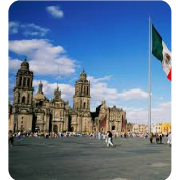

In [108]:
img = tf.keras.utils.load_img(
    data_dir+'/cdmx/(17155).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img

## Use TensorFlow Lite

### Convert the Keras Sequential model to a TensorFlow Lite model


In [110]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model6.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0sr5ezq6/assets


INFO:tensorflow:Assets written to: /tmp/tmp0sr5ezq6/assets
2024-02-23 22:04:10.394262: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-23 22:04:10.394388: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-23 22:04:10.394756: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp0sr5ezq6
2024-02-23 22:04:10.397921: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-23 22:04:10.397984: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp0sr5ezq6
2024-02-23 22:04:10.405223: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-23 22:04:10.529167: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp0sr5ezq6
2024-02-23 22:04:10.548806: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

### Run the TensorFlow Lite model

In [111]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [112]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_7_input'], 'outputs': ['outputs']}}

In [113]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [114]:
predictions_lite = classify_lite(sequential_7_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

1/1 [==============================] - 0s 47ms/step
This image most likely belongs to shanhaiguan with a 91.54 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan']
[0.02135005 0.03292508 0.01313934 0.01448511 0.00266839 0.91543204]


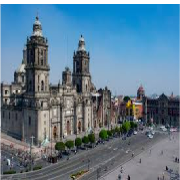

In [116]:
img = tf.keras.utils.load_img(
    data_dir+'/cdmx/(17503).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img

In [117]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to shanhaiguan with a 82.05 percent confidence.
